<a href="https://colab.research.google.com/github/junyu-chen-academic/Transformer/blob/main/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
######################################
### importing libraries
######################################
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, TensorDataset, DataLoader

seed = 2024
torch.manual_seed(seed)

# 1. Data Preprocessing

## 1.1 Word Embedding

In [2]:
###########################################################
###########################################################
# tokenize the sequences
def tokenize(sequence):

    # remove punctuation
    for punc in ["!", ",", ".", "?"]:
        sequence = sequence.replace(punc, "")

    # split the sequence on spaces and lowercase each token
    return [token.lower() for token in sequence.split(" ")]

def build_vocab(data):

    # tokenize the data and remove duplicates
    vocab = list(set(tokenize(data)))

    # sort the vocabulary
    vocab.sort()

    # assign an integer to each word
    vocab = {word:i for i, word in enumerate(vocab)}

    return vocab

## 1.2 Positional Encoding

The original mapping we applied in positional encoding is
$$
\begin{align}
    p_{k,2i} &= \sin(\frac{k}{10000^{\frac{2i}{d}}}), \\
    p_{k,2i+1} &= \cos(\frac{k}{10000^{\frac{2i}{d}}}),
\end{align}
$$
for $k \in \{1, \ldots, n\}$ and $i \in \{0, \ldots, \frac{d}{2} - 1\}$. However, this basic implementation is not efficient due to its use of nested loops.

Instead, we modify the divisor using logarithmic rules:
$$
\begin{align}
    \frac{1}{10000^{\frac{2i}{d}}} = e^{\frac{-2i \log(n)}{d}}.
\end{align}
$$
It is apparent that only two divisors are necessary for a $4$-dimensional embedding since the divisor only changes every $2i$.

In [3]:
###########################################################
###########################################################
class PositionalEncoding(nn.Module):

    def __init__(
        self,
        d_model: int,
        dropout: float = 0.0,
        max_length: int = 5000
    ):
        """
        Args:
          d_model:      dimension of embeddings
          dropout:      probability of randomly zeroes-out some of the input
          max_length:   max sequence length
        """
        super().__init__()

        # initialize dropout
        self.dropout = nn.Dropout(p=dropout)
        # create a N x d tensor of zeros
        pe = torch.zeros(max_length, d_model)

        # calculate the numerator
        # unsqueeze(1) adds a new dimension at the first axis (index 1), transforming the 1D tensor into a 2D column vector.
        k = torch.arange(0, max_length).unsqueeze(1)

        # calculate the denominator
        div_term = torch.exp(torch.arange(0, d_model, 2) * (- (math.log(10000.0) / d_model)))

        # calculate sine on even indices, and cosine on odd indices.
        pe[:, 0::2] = torch.sin(k * div_term)
        pe[:, 1::2] = torch.cos(k * div_term)

        # add dimension
        pe = pe.unsqueeze(0)

        # buffers are saved in state_dict but not trained by the optimizer
        self.register_buffer("pe", pe)

    def forward(self, x: Tensor):
        """
        Args:
          x:        input embeddings (batch_size, seq_length, d_model)

        Returns:    embeddings + positional encodings (batch_size, seq_length, d_model)
        """
        # add positional encoding to the embeddings
        # note that the positional encoding tensor is sliced to match the length of the input sequence.
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)

        # perform dropout
        return self.dropout(x)

# 2. Model

Things to note:

1. we use nn.dropout to prevent overfitting. Dropout randomly zeroes out some values of the output.

2. We use the fully connected neural network in the feed forward layer.

## 2.1 Layers

### 2.1.1 Attention Layer

Each head undergoes single-head attention operation multiple times to obtain different attention scores:
$$
\begin{align}
    \mathbf{A}'_{(h)} &= \text{Attention}(\mathbf{Q}_{(h)},\mathbf{K}_{(h)},\mathbf{V}_{(h)}) = \text{softmax}(\frac{\mathbf{Q}_{(h)}\mathbf{K}_{(h)}^T}{\sqrt{d_{k}}})\mathbf{V}_{(h)}, \\
    \text{where }&
    \mathbf{Q}_{(h)}=\mathbf{X} \mathbf{W}_{q}^{(h)}, \quad
    \mathbf{K}_{(h)}=\mathbf{X} \mathbf{W}_{k}^{(h)}, \quad
    \mathbf{V}_{(h)}=\mathbf{X} \mathbf{W}_{v}^{(h)}.
\end{align}
$$

Here, $h$ denotes the number of heads, often $d_{k} = d_{v} = d/h$, and $\mathbf{W}_{q}^{(h)}, \mathbf{W}_{k}^{(h)}, \mathbf{W}_{v}^{(h)} \in \mathbb{R}^{d \times d_{k}}$.

Then, we concatenate attention outputs $\mathbf{A}'_{(h)}$ from all $h$ heads and linearly combine using a learnable weight matrix $\mathbf{W}_{a} \in \mathbb{R}^{hd_{v}\times d}$:
\begin{equation}
    \mathbf{A} = \text{Multi-Head}(\mathbf{Q},\mathbf{K},\mathbf{V}) = \text{Concat}(\mathbf{A}'_{(1)}, ..., \mathbf{A}'_{(h)}) \cdot W_{a},
\end{equation}
where $\mathbf{A} \in \mathbb{R}^{n \times d}$.

Note that the softmax function $\sigma : \mathbb{R}^{n} \rightarrow \mathbb{R}^{n}$ is defined by the formula: $\sigma(\mathbf{z})_{i} = e^{z_{i}}/\sum_{j=1}^{n} e^{z_{j}}$ for $i = \{1,...,n\}$.

In [4]:
###########################################################
###########################################################
class MultiHeadAttention(nn.Module):

    def __init__(
        self,
        d_model: int = 512,
        n_heads: int = 8,
        dropout: float = 0.1,
        bias: bool = True
    ):
        """
        Args:
            d_model:      dimension of embeddings
            n_heads:      number of self attention heads
            dropout:      probability of dropout occurring
        """
        super().__init__()
        torch.manual_seed(seed)
        assert d_model % n_heads == 0            # ensure an even num of heads
        self.d_model = d_model                   # dim (e.g. 512)
        self.n_heads = n_heads                   # 8 heads
        self.d_key = d_model // n_heads          # assume d_value equals d_key (e.g. 512/8=64)
        self.bias = bias                         # bias

        self.Wq = nn.Linear(d_model, d_model, bias)    # query weights
        self.Wk = nn.Linear(d_model, d_model, bias)    # key weights
        self.Wv = nn.Linear(d_model, d_model, bias)    # value weights
        self.Wo = nn.Linear(d_model, d_model, bias)    # output weights

        self.dropout = nn.Dropout(p=dropout)     # initialize dropout layer

    def forward(
        self,
        query: Tensor,
        key: Tensor,
        value: Tensor,
        mask: Tensor = None
    ):
        """
        Args:
           query:         query vector         (batch_size, q_length, d_model)
           key:           key vector           (batch_size, k_length, d_model)
           value:         value vector         (batch_size, s_length, d_model)
           mask:          mask for decoder

        Returns:
           output:        attention values     (batch_size, q_length, d_model)
           attn_probs:    softmax scores       (batch_size, n_heads, q_length, k_length)
        """
        batch_size = key.size(0)

        # calculate query, key, and value tensors
        Q = self.Wq(query)                       # (32, 10, 512) x (512, 512) = (32, 10, 512)
        K = self.Wk(key)                         # (32, 10, 512) x (512, 512) = (32, 10, 512)
        V = self.Wv(value)                       # (32, 10, 512) x (512, 512) = (32, 10, 512)

        # split each tensor into n-heads to compute attention

        # query tensor
        Q = Q.view(batch_size,                   # (32, 10, 512) -> (32, 10, 8, 64)
                   -1,                           # -1 = q_length, -1 allows PyTorch to infer this.
                   self.n_heads,
                   self.d_key
                   ).permute(0, 2, 1, 3)         # (32, 10, 8, 64) -> (32, 8, 10, 64) = (batch_size, n_heads, q_length, d_key)
        # key tensor
        K = K.view(batch_size,                   # (32, 10, 512) -> (32, 10, 8, 64)
                   -1,                           # -1 = k_length, -1 allows PyTorch to infer this.
                   self.n_heads,
                   self.d_key
                   ).permute(0, 2, 1, 3)         # (32, 10, 8, 64) -> (32, 8, 10, 64) = (batch_size, n_heads, k_length, d_key)
        # value tensor
        V = V.view(batch_size,                   # (32, 10, 512) -> (32, 10, 8, 64)
                   -1,                           # -1 = v_length, -1 allows PyTorch to infer this.
                   self.n_heads,
                   self.d_key
                   ).permute(0, 2, 1, 3)         # (32, 10, 8, 64) -> (32, 8, 10, 64) = (batch_size, n_heads, v_length, d_key)

        # computes attention
        # scaled dot product -> QK^{T} / sqrt(d_key)
        # (32, 8, 10, 64) x (32, 8, 64, 10) -> (32, 8, 10, 10) = (batch_size, n_heads, q_length, k_length)
        scaled_dot_prod = torch.matmul(Q, K.permute(0, 1, 3, 2)) / math.sqrt(self.d_key)      # sqrt(64)

        # fill those positions of product as (-1e10) where mask positions are 0
        if mask is not None:
            scaled_dot_prod = scaled_dot_prod.masked_fill(mask == 0, -1e10)

        # apply softmax
        attn_probs = torch.softmax(scaled_dot_prod, dim=-1)

        # multiply by values to get attention
        A = torch.matmul(self.dropout(attn_probs), V)       # (32, 8, 10, 10) x (32, 8, 10, 64) -> (32, 8, 10, 64)
                                                            # (batch_size, n_heads, q_length, k_length) x (batch_size, n_heads, v_length, d_key) -> (batch_size, n_heads, q_length, d_key)

        # reshape attention back to (32, 10, 512)
        A = A.permute(0, 2, 1, 3).contiguous()              # (32, 8, 10, 64) -> (32, 10, 8, 64)
        A = A.view(batch_size, -1, self.n_heads * self.d_key) # (32, 10, 8, 64) -> (32, 10, 8*64) -> (32, 10, 512) = (batch_size, q_length, d_model)

        # push through the final weight layer
        output = self.Wo(A)                                 # (32, 10, 512) x (512, 512) = (32, 10, 512)

        return output, attn_probs                           # return attn_probs for visualization of the scores

### 2.1.2 Add and Norm Layer

Layer normalization speeds up convergence.

The LayerNorm function $g: \mathbb{R}^{n} \rightarrow \mathbb{R}^{n}$ is defined by $g(\mathbf{z}, \gamma, \beta)_{i} = \beta + \gamma \frac{(z_{i} - \mu_{z})}{\sigma_{z}}$. Here, $\mu_{z} = \frac{1}{n} \sum_{i=1}^{n} z_{i}$ and $\sigma_{z} = \sqrt{\frac{1}{n} \sum_{i=1}^{n}(z_{i} - \mu_{z})^{2})}$ denote the mean and standard deviation respectively, $\gamma$ and $\beta$ are parameters of the LayerNorm function. After normalization, the input is scaled by $\gamma$ and shifted by $\beta$.

In [5]:
###########################################################
###########################################################
class LayerNorm(nn.Module):

    def __init__(
        self,
        d_model,
        eps=1e-5
    ):
        super().__init__()
        # initialize gamma to be all ones
        self.gamma = nn.Parameter(torch.ones(d_model))
        # initialize beta to be all zeros
        self.beta = nn.Parameter(torch.zeros(d_model))
        # eps: a small constant (1e-5) added to the variance to avoid division by zero during normalization.
        self.eps = eps

    def forward(self, src):
        # this computes the mean of the input src along the last dimension (-1), which represents the feature dimension.
        mean = src.mean(-1, keepdim=True)
        # this computes the variance of the input src along the last dimension (-1). unbiased=False means not divided by n-1 but by n.
        var = src.var(-1, keepdim=True, unbiased=False)
        # return the normalized value
        return self.gamma * (src - mean) / torch.sqrt(var + self.eps) + self.beta

### 2.1.3 Feed Forward Layer

It consists of two linear layers.

In [6]:
###########################################################
###########################################################
class PositionwiseFeedForward(nn.Module):

  def __init__(
      self,
      d_model: int,
      d_ffn: int,
      dropout: float = 0.1
  ):
    """
    Args:
        d_model:      dimension of embeddings
        d_ffn:        dimension of feed-forward network,
                      generally set to a value about four times that of d_model.
        dropout:      probability of dropout occurring
    """
    super().__init__()

    self.w_1 = nn.Linear(d_model, d_ffn)
    self.w_2 = nn.Linear(d_ffn, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    """
    Args:
        x:            output from attention (batch_size, seq_length, d_model)

    Returns:
        expanded-and-contracted representation (batch_size, seq_length, d_model)
    """
    # w_1(x).relu():            (batch_size, seq_length, d_model) x (d_model, d_ffn)  ->    (batch_size, seq_length, d_ffn)
    # w_2(w_1(x).relu()):       (batch_size, seq_length, d_ffn) x (d_ffn, d_model)    ->    (batch_size, seq_length, d_model)
    return self.w_2(self.dropout(self.w_1(x).relu()))

## 2.2 Encoder-Decoder Structure

### 2.2.1 Encoder Block

Stacking each encoder layer forms the encoder block. The original paper by Vaswani et al. stacked 6 encoder layers.



In [7]:
###########################################################
###########################################################
class EncoderLayer(nn.Module):

    def __init__(
        self,
        d_model: int,
        n_heads: int,
        d_ffn: int,
        dropout: float
    ):
        """
        Args:
            d_model:      dimension of embeddings
            n_heads:      number of heads
            d_ffn:        dimension of feed-forward network
            dropout:      probability of dropout occurring
        """
        super().__init__()

        # multi-head attention sublayer
        self.attention = MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout=dropout)
        # layer norm for multi-head attention
        self.attn_layer_norm = LayerNorm(d_model=d_model)

        # position-wise feed-forward network
        self.positionwise_ffn = PositionwiseFeedForward(d_model=d_model, d_ffn=d_ffn, dropout=dropout)
        # layer norm for position-wise ffn
        self.ffn_layer_norm = LayerNorm(d_model=d_model)

        self.dropout = nn.Dropout(p=dropout)

    def forward(
        self,
        src: Tensor,
        src_mask: Tensor
    ):
        """
        Args:
            src:          positionally embedded sequences   (batch_size, seq_length, d_model)
            src_mask:     mask for the sequences            (batch_size, 1, 1, seq_length)

        Returns:
            src:          sequences after self-attention    (batch_size, seq_length, d_model)
        """
        # pass embeddings through multi-head attention
        _src, attn_probs = self.attention(query=src, key=src, value=src, mask=src_mask)

        # residual add and norm
        src = self.attn_layer_norm(src + self.dropout(_src))

        # position-wise feed-forward network
        _src = self.positionwise_ffn(x=src)

        # residual add and norm
        src = self.ffn_layer_norm(src + self.dropout(_src))

        return src, attn_probs


###########################################################
###########################################################
class Encoder(nn.Module):

    def __init__(
        self,
        d_model: int,
        n_layers: int,
        n_heads: int,
        d_ffn: int,
        dropout: float = 0.1
    ):
        """
        Args:
            d_model:      dimension of embeddings
            n_layers:     number of encoder layers
            n_heads:      number of heads
            d_ffn:        dimension of feed-forward network
            dropout:      probability of dropout occurring
        """
        super().__init__()

        # create n_layers encoders
        self.layers = nn.ModuleList(
            [EncoderLayer(d_model=d_model, n_heads=n_heads, d_ffn=d_ffn, dropout=dropout) for layer in range(n_layers)]
        )

        self.dropout = nn.Dropout(p=dropout)

    def forward(
        self,
        src: Tensor,
        src_mask: Tensor
    ):
        """
        Args:
            src:          embedded sequences                (batch_size, seq_length, d_model)
            src_mask:     mask for the sequences            (batch_size, 1, 1, seq_length)

        Returns:
            src:          sequences after self-attention    (batch_size, seq_length, d_model)
        """

        # pass the sequences through each encoder
        for layer in self.layers:
            src, attn_probs = layer(src=src, src_mask=src_mask)

        self.attn_probs = attn_probs

        return src

### 2.2.2 Decoder Block

Stacking each decoder layer forms the decoder block. The original paper by Vaswani et al. stacked 6 decoder layers.

In [8]:

###########################################################
###########################################################
class DecoderLayer(nn.Module):

    def __init__(
        self,
        d_model: int,
        n_heads: int,
        d_ffn: int,
        dropout: float
    ):
        """
        Args:
            d_model:      dimension of embeddings
            n_heads:      number of heads
            d_ffn:        dimension of feed-forward network
            dropout:      probability of dropout occurring
        """
        super().__init__()
        # masked multi-head attention sublayer
        self.masked_attention = MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout=dropout)
        # layer norm for masked multi-head attention
        self.masked_attn_layer_norm = LayerNorm(d_model=d_model)

        # multi-head attention sublayer
        self.attention = MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout=dropout)
        # layer norm for multi-head attention
        self.attn_layer_norm = LayerNorm(d_model=d_model)

        # position-wise feed-forward network
        self.positionwise_ffn = PositionwiseFeedForward(d_model=d_model, d_ffn=d_ffn, dropout=dropout)
        # layer norm for position-wise ffn
        self.ffn_layer_norm = LayerNorm(d_model=d_model)

        self.dropout = nn.Dropout(p=dropout)

    def forward(
        self,
        trg: Tensor,
        src: Tensor,
        trg_mask: Tensor,
        src_mask: Tensor
    ):
        """
        Args:
            trg:          target embedded sequences                (batch_size, trg_seq_length, d_model)
            src:          source embedded sequences                (batch_size, src_seq_length, d_model)
            trg_mask:     mask for the target sequences            (batch_size, 1, trg_seq_length, trg_seq_length)
            src_mask:     mask for the source sequences            (batch_size, 1, 1, src_seq_length)

        Returns:
            trg:          sequences after self-attention    (batch_size, trg_seq_length, d_model)
            attn_probs:   attention softmax scores          (batch_size, n_heads, trg_seq_length, src_seq_length)
        """
        # pass trg embeddings through masked multi-head attention
        _trg, attn_probs = self.masked_attention(query=trg, key=trg, value=trg, mask=trg_mask)

        # residual add and norm
        trg = self.masked_attn_layer_norm(trg + self.dropout(_trg))

        # pass trg and src embeddings through multi-head attention
        _trg, attn_probs = self.attention(query=trg, key=src, value=src, mask=src_mask)

        # residual add and norm
        trg = self.attn_layer_norm(trg + self.dropout(_trg))

        # position-wise feed-forward network
        _trg = self.positionwise_ffn(x=trg)

        # residual add and norm
        trg = self.ffn_layer_norm(trg + self.dropout(_trg))

        return trg, attn_probs

###########################################################
###########################################################
class Decoder(nn.Module):

    def __init__(
        self,
        vocab_size: int,
        d_model: int,
        n_layers: int,
        n_heads: int,
        d_ffn: int,
        dropout: float = 0.1
    ):
        """
        Args:
            vocab_size:   size of the vocabulary
            d_model:      dimension of embeddings
            n_layers:     number of encoder layers
            n_heads:      number of heads
            d_ffn:        dimension of feed-forward network
            dropout:      probability of dropout occurring
        """
        super().__init__()

        # create n_layers encoders
        self.layers = nn.ModuleList(
            [DecoderLayer(d_model=d_model, n_heads=n_heads, d_ffn=d_ffn, dropout=dropout) for layer in range(n_layers)]
        )
        self.dropout = nn.Dropout(p=dropout)
        # set output layer
        self.Wo = nn.Linear(d_model, vocab_size)

    def forward(
        self,
        trg: Tensor,
        src: Tensor,
        trg_mask:
        Tensor,
        src_mask: Tensor
    ):
        """
        Args:
            trg:          embedded sequences                (batch_size, trg_seq_length, d_model)
            src:          encoded sequences from encoder    (batch_size, src_seq_length, d_model)
            trg_mask:     mask for the sequences            (batch_size, 1, trg_seq_length, trg_seq_length)
            src_mask:     mask for the sequences            (batch_size, 1, 1, src_seq_length)

        Returns:
            output:       sequences after decoder           (batch_size, trg_seq_length, vocab_size)
            attn_probs:   self-attention softmax scores     (batch_size, n_heads, trg_seq_length, src_seq_length)
        """

        # pass the sequences through each decoder
        for layer in self.layers:
            trg, attn_probs = layer(trg=trg, src=src, trg_mask=trg_mask, src_mask=src_mask)

        self.attn_probs = attn_probs

        return self.Wo(trg)

# 4. Atttention applied to Time Series

We use the attention mechanism followed by a feed-forward layer.

**Model Structure:**

The _TimeSeriesAttention_ is a neural network model designed to predict time series data using attention mechanisms. Here's a brief description of the structure
- MultiHeadAttention Layer: capture dependencies in time series data.

- Linear Layers: passes the attention output through two linear layers with a ReLU activation to predict a single value:
  - The first linear layer maps the sequence back to its original length.
  - The second reduces the sequence to a single prediction value.

- Masking: A masking option prevents attention to future time steps.

In [9]:
class TimeSeriesAttention(nn.Module):
    def __init__(
        self,
        sequence_length: int,
        d_model: int = 512,
        n_heads: int = 8,
        dropout: float = 0.1,
        bias: bool = True
    ):
        super().__init__()
        self.attention = MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout=dropout, bias=False)
        self.linear_layer1 = nn.Linear(sequence_length, sequence_length, bias)
        self.linear_layer2 = nn.Linear(sequence_length, 1, bias)
        self.relu = nn.ReLU()

    def forward(
        self,
        x: Tensor,
        mask_or_not: bool = True
    ):
        if mask_or_not == True:
          mask_matrix = torch.tril(torch.ones((x.size(1), x.size(1))))
          attention_out, _ = self.attention(x, x, x, mask_matrix)  # Using same input for query, key, value
        else:
          attention_out, _ = self.attention(x, x, x)  # Using same input for query, key, value

        # remove the d_model, as we want the 200 points in sequence to be mapped to 1 target
        # (batch_size, sequence_length, d_model) -> (batch_size, sequence_length)
        attention_out = attention_out.squeeze(-1)
        output = self.linear_layer2(attention_out)
        #output = self.relu(output)
        #output = self.linear_layer2(output)
        #output = self.relu(output)
        #output = self.linear_layer3(output)
        return output

## 4.1 Predict AR(1)

1. The dataset consists of **1000 data points**.

2. The first 80% of the time series is used to train the model. The remaining 20% is used for testing.

3. Train data
  * Input: **800 sequences, 1 lags, 1 dimension** = (800 x 1 x 1)
  * Targets: **800 targets, 1 dimension** = (800 x 1)


3. Test data
  * Input: **200 sequences, 1 lags, 1 dimension** = (200 x 1 x 1)
  * Targets: **200 targets, 1 dimension** = (200 x 1)


The general form of the AR(1) model is:

$$
y_t = \phi y_{t-1} + \epsilon_t,
$$

where:
- $y_t$ is the value of the time series at time $t$,
- $\phi$ is the autoregressive coefficient (usually $|\phi| < 1$ for stationarity),
- $\epsilon_t$ is a white noise term with zero mean and constant variance (usually $\epsilon_t \sim N(0, \sigma^2)$).

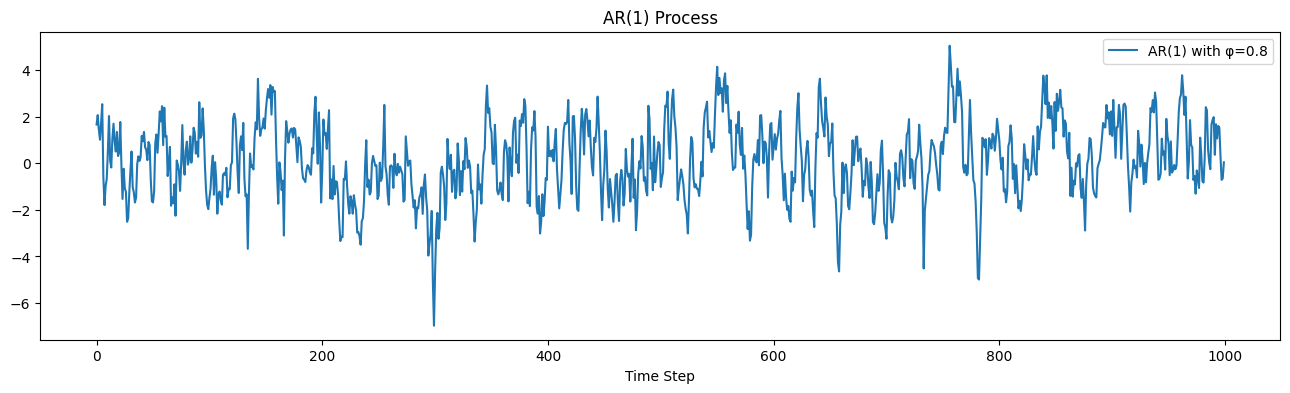

X: (999, 1, 1)
Y: (999, 1)
X_train: (800, 1, 1) Y_train: (800, 1)
X_test: (199, 1, 1) Y_test: (199, 1)


In [10]:
######################################
### Data Generation Process AR(1)
######################################
#phi = 0.1
phi = 0.8
sigma = 1  # sd. of noise
n = 1000  # number of time points

torch.manual_seed(seed)
np.random.seed(seed)
######################################

y_ar1 = np.zeros(n)

# generate white noise
epsilon = np.random.normal(0, sigma, n)

# initialize the first value of the series
y_ar1[0] = epsilon[0]

# generate AR(1) time series
for t in range(1, n):
    y_ar1[t] = phi * y_ar1[t-1] + epsilon[t]
    #y_ar1[t] = np.sin(y_ar1[t-1]) + epsilon[t]

# plot the generated AR(1) series
plt.figure(figsize=(16, 4))
plt.plot(y_ar1, label=f'AR(1) with φ={phi}')
plt.title('AR(1) Process')
plt.xlabel('Time Step')
plt.legend()
plt.show()

######################################
### Input Data Setting
######################################
sequence_length = 1 # number of time steps per input sequence
d_model = 1 # dimension
batch_size = 32
######################################

# create X (lagged values, y_{t-1})
X = y_ar1[:-1].reshape(-1, sequence_length, d_model) # reshape to (batch_size, sequence_length, d_model)
# create Y (current values, y_{t})
Y = y_ar1[1:].reshape(-1, d_model) # reshape to (batch_size, d_model)

print(f"X: {X.shape}")
print(f"Y: {Y.shape}")

# split into train (80%) and test (20%) data
split_index = int(0.8 * n)

X_train, Y_train = X[:split_index], Y[:split_index]
X_test, Y_test = X[split_index:], Y[split_index:]

print("X_train:", X_train.shape, "Y_train:", Y_train.shape)
print("X_test:", X_test.shape, "Y_test:", Y_test.shape)

# create a DataLoader
dataset_train = TensorDataset(Tensor(X_train), Tensor(Y_train))
dataset_test = TensorDataset(Tensor(X_test), Tensor(Y_test))

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [11]:
######################################
### Model training
######################################
n_heads = 1
dropout = 0
learning_rate = 0.0015
epochs = 20

torch.manual_seed(seed)
np.random.seed(seed)
######################################

# model initialization
model_ar1 = TimeSeriesAttention(sequence_length=sequence_length, d_model=d_model, n_heads=n_heads, dropout=dropout, bias=True)

# train the model
model_ar1.train()
optimizer = torch.optim.Adam(model_ar1.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

for epoch in range(epochs):

  for input, target in dataloader_train:

    optimizer.zero_grad()
    # forward pass
    predicted = model_ar1(input, mask_or_not=True)
    # calculate loss
    loss = criterion(predicted, target)
    # backward pass
    loss.backward()
    # optimization
    optimizer.step()

  print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss:.4f}")

# print the well-trained weights
print("#"*20,"\nTrained Model Weights:")
for name, param in model_ar1.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.data}")

Epoch [1/20], Loss: 1.7293
Epoch [2/20], Loss: 1.0004
Epoch [3/20], Loss: 1.2634
Epoch [4/20], Loss: 1.5382
Epoch [5/20], Loss: 1.3728
Epoch [6/20], Loss: 0.9443
Epoch [7/20], Loss: 0.9371
Epoch [8/20], Loss: 0.8582
Epoch [9/20], Loss: 0.6206
Epoch [10/20], Loss: 1.3856
Epoch [11/20], Loss: 0.7832
Epoch [12/20], Loss: 0.5642
Epoch [13/20], Loss: 1.1280
Epoch [14/20], Loss: 0.8550
Epoch [15/20], Loss: 0.6722
Epoch [16/20], Loss: 0.6105
Epoch [17/20], Loss: 0.7136
Epoch [18/20], Loss: 1.0770
Epoch [19/20], Loss: 0.8475
Epoch [20/20], Loss: 0.9541
#################### 
Trained Model Weights:
attention.Wq.weight: tensor([[0.0634]])
attention.Wk.weight: tensor([[0.6625]])
attention.Wv.weight: tensor([[1.1181]])
attention.Wo.weight: tensor([[-0.9346]])
linear_layer1.weight: tensor([[-0.6662]])
linear_layer1.bias: tensor([-0.3011])
linear_layer2.weight: tensor([[-0.7412]])
linear_layer2.bias: tensor([0.0056])


Mean Squared Error on Test Data: 0.8629


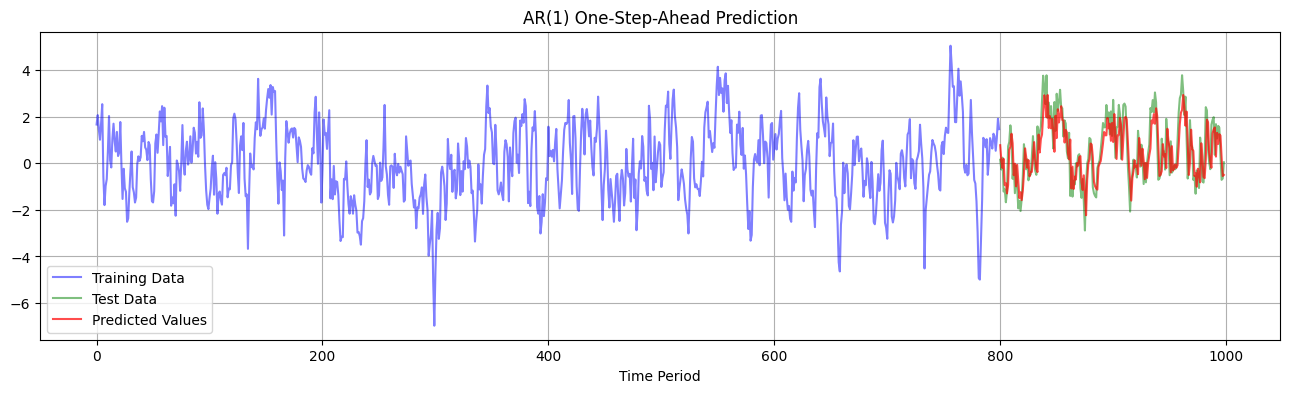

In [12]:
######################################
### Model Evaluation
######################################
model_ar1.eval()

# lists
predictions = []
actuals = []

with torch.no_grad():
  for input, target in dataloader_test:
    # perform forward pass
    predicted = model_ar1(input, mask_or_not=True)

    # store predictions and actual values
    predictions.append(predicted.numpy())
    actuals.append(target.numpy())

# convert the lists to numpy arrays
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# calculate MSE for evaluation
mse = np.mean((predictions - actuals) ** 2)
print(f"Mean Squared Error on Test Data: {mse:.4f}")


plt.figure(figsize=(16, 4))

# plot trained data (y values)
plt.plot(np.arange(split_index), y_ar1[:split_index], label='Training Data', color='blue', alpha=0.5)
# plot test data (y values)
plt.plot(np.arange(split_index, n-1), actuals, label='Test Data', color='green', alpha=0.5)
# plot predictions on test data
plt.plot(np.arange(split_index, n-1), predictions, label='Predicted Values', color='red', alpha=0.7)

plt.title('AR(1) One-Step-Ahead Prediction')
plt.xlabel('Time Period')
plt.legend()
plt.grid()
plt.show()

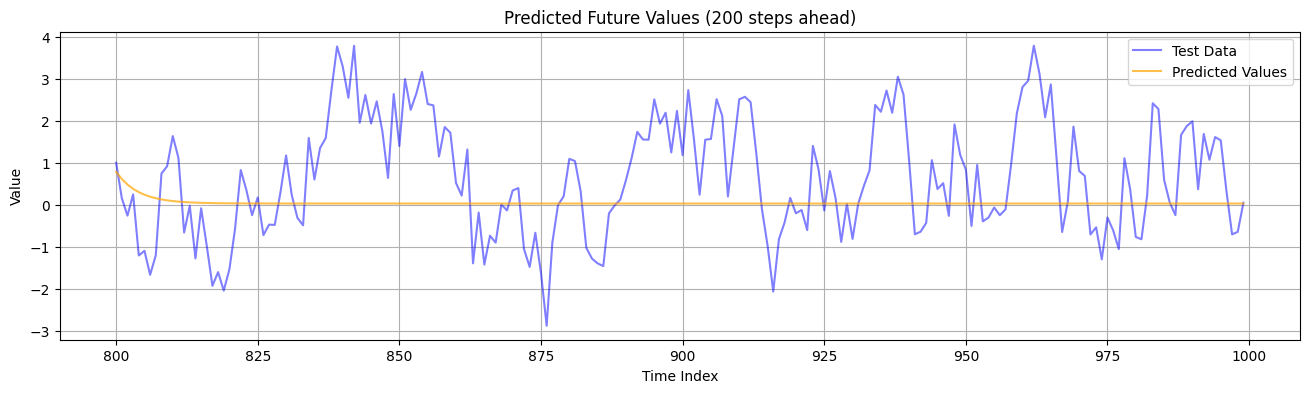

In [13]:
step_ahead = 200

# start with the first point in the test set
initial_input = X_test[0].reshape(1, sequence_length, d_model)
initial_input = torch.Tensor(initial_input)

future_predictions = []

# predict 200 time steps ahead
with torch.no_grad():

  current_input = initial_input
  for _ in range(200):
    # predict the next time step
    predicted = model_ar1(current_input, mask_or_not=False)

    # Store the predicted value
    future_predictions.append(predicted.item())

    # Use the predicted value as the next input
    current_input = predicted.reshape(1, sequence_length, d_model)

future_predictions = np.array(future_predictions)

# plot the predictions along with the test data for comparison
plt.figure(figsize=(16, 4))
# plot the test data (first point and onward)
plt.plot(np.arange(split_index, split_index + 200), y_ar1[split_index:split_index + 200], label='Test Data', color='blue', alpha=0.5)
# plot the predicted values
plt.plot(np.arange(split_index, split_index + 200), future_predictions, label='Predicted Values', color='orange', alpha=0.7)

plt.title('Predicted Future Values (200 steps ahead)')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

## 4.2 Predict AR(2)

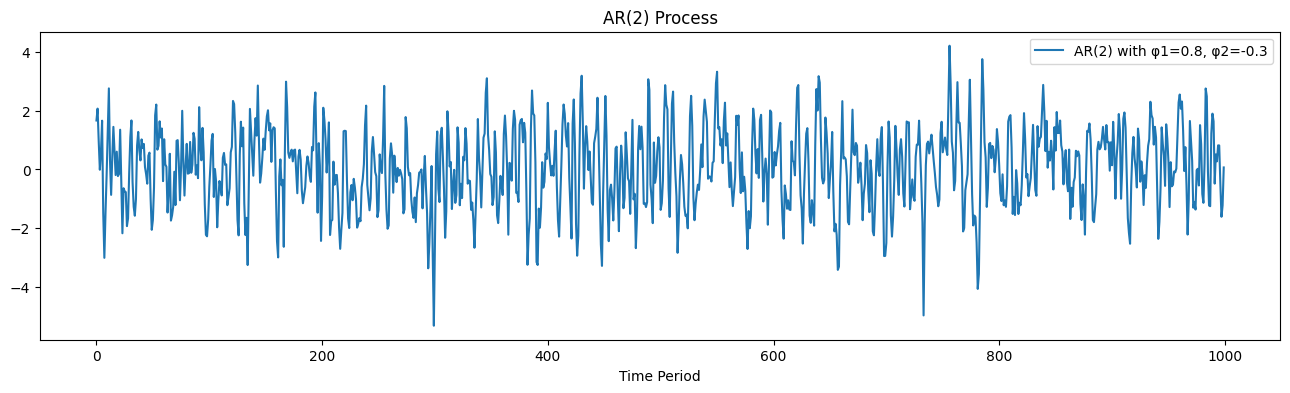

In [14]:
######################################
### Data Generation Process AR(2)
######################################
phi1 = 0.8
phi2 = -0.3
sigma = 1  # sd. of noise
n = 1000  # number of time points

torch.manual_seed(seed)
np.random.seed(seed)
######################################

y_ar2 = np.zeros(n)

# generate white noise
epsilon = np.random.normal(0, sigma, n)

# initialize the first two values of the series
y_ar2[0] = epsilon[0]
y_ar2[1] = phi1 * y_ar2[0] + epsilon[1]

# Generate AR(2) time series
for t in range(2, n):
    y_ar2[t] = phi1 * y_ar2[t-1] + phi2 * y_ar2[t-2] + epsilon[t]

# Plot the generated AR(2) series
plt.figure(figsize=(16, 4))
plt.plot(y_ar2, label=f'AR(2) with φ1={phi1}, φ2={phi2}')
plt.title('AR(2) Process')
plt.xlabel('Time Period')
plt.legend()
plt.show()

In [15]:
######################################
### Input Data Setting
######################################
sequence_length = 2 # number of time steps per input sequence
d_model = 1 # dimension
batch_size = 32
######################################

X_ar2 = np.zeros((n-sequence_length, sequence_length, d_model))
Y_ar2 = np.zeros((n-sequence_length, d_model))
for t in range(sequence_length, n):
  X_ar2[t-sequence_length, :, 0] = y_ar2[t-sequence_length:t]  # X is the two previous values
  Y_ar2[t-sequence_length, 0] = y_ar2[t]  # Y is the current value

print(f"X: {X.shape}")
print(f"Y: {Y.shape}")

# split into train (80%) and test (20%) data
split_index = int(0.8 * n)

X_train_ar2, Y_train_ar2 = X_ar2[:split_index], Y_ar2[:split_index]
X_test_ar2, Y_test_ar2 = X_ar2[split_index:], Y_ar2[split_index:]

print("X_train:", X_train_ar2.shape, "Y_train:", Y_train_ar2.shape)
print("X_test:", X_test_ar2.shape, "Y_test:", Y_test_ar2.shape)

# create a DataLoader
dataset_train_ar2 = TensorDataset(Tensor(X_train_ar2), Tensor(Y_train_ar2))
dataset_test_ar2 = TensorDataset(Tensor(X_test_ar2), Tensor(Y_test_ar2))

dataloader_train_ar2 = DataLoader(dataset_train_ar2, batch_size=batch_size, shuffle=True)
dataloader_test_ar2 = DataLoader(dataset_test_ar2, batch_size=batch_size, shuffle=False)

X: (999, 1, 1)
Y: (999, 1)
X_train: (800, 2, 1) Y_train: (800, 1)
X_test: (198, 2, 1) Y_test: (198, 1)


In [16]:
######################################
### Model training
######################################
n_heads = 1
dropout = 0
learning_rate = 0.0015
epochs = 20

torch.manual_seed(seed)
np.random.seed(seed)
######################################

# model initialization
model_ar2 = TimeSeriesAttention(sequence_length=sequence_length, d_model=d_model, n_heads=n_heads, dropout=dropout, bias=False)

# train the model
model_ar2.train()
optimizer = torch.optim.Adam(model_ar2.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

for epoch in range(epochs):

  for input, target in dataloader_train_ar2:

    optimizer.zero_grad()
    # forward pass
    predicted = model_ar2(input, mask_or_not=True)
    # calculate loss
    loss = criterion(predicted, target)
    # backward pass
    loss.backward()
    # optimization
    optimizer.step()

  print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss:.4f}")

# print the well-trained weights
print("#"*20,"\nTrained Model Weights:")
for name, param in model_ar2.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.data}")

Epoch [1/20], Loss: 2.9438
Epoch [2/20], Loss: 1.1325
Epoch [3/20], Loss: 1.7892
Epoch [4/20], Loss: 3.1521
Epoch [5/20], Loss: 2.1086
Epoch [6/20], Loss: 2.0137
Epoch [7/20], Loss: 2.8804
Epoch [8/20], Loss: 2.5375
Epoch [9/20], Loss: 2.3357
Epoch [10/20], Loss: 2.8879
Epoch [11/20], Loss: 1.8835
Epoch [12/20], Loss: 1.9931
Epoch [13/20], Loss: 2.2785
Epoch [14/20], Loss: 1.7206
Epoch [15/20], Loss: 1.8581
Epoch [16/20], Loss: 1.9604
Epoch [17/20], Loss: 2.2438
Epoch [18/20], Loss: 1.7789
Epoch [19/20], Loss: 1.7490
Epoch [20/20], Loss: 1.8374
#################### 
Trained Model Weights:
attention.Wq.weight: tensor([[-0.1556]])
attention.Wk.weight: tensor([[0.8408]])
attention.Wv.weight: tensor([[0.7519]])
attention.Wo.weight: tensor([[-0.5660]])
linear_layer1.weight: tensor([[-0.4711, -0.2129],
        [-0.4031,  0.1699]])
linear_layer2.weight: tensor([[-0.2040, -0.0773]])


Mean Squared Error on Test Data: 1.3335


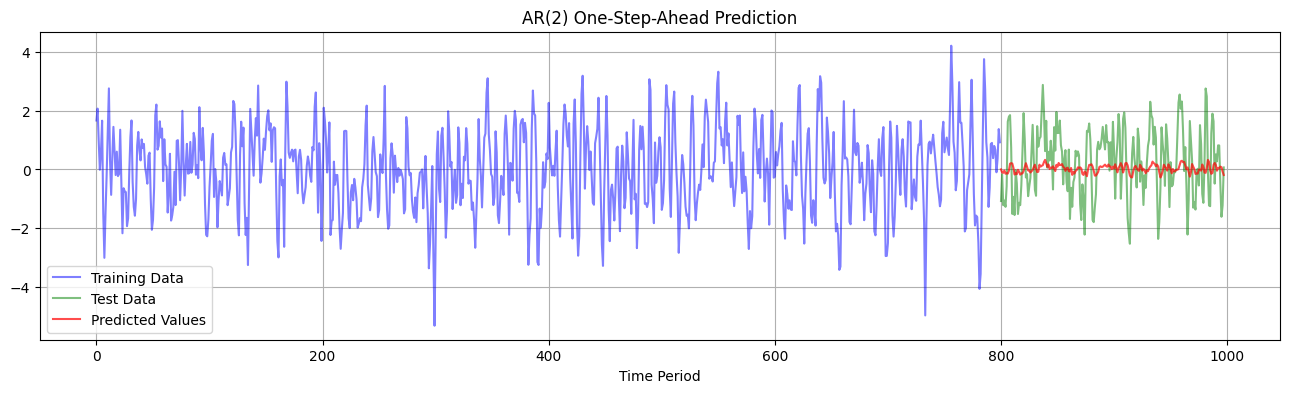

In [17]:
######################################
### Model Evaluation
######################################
model_ar2.eval()

# lists
predictions = []
actuals = []

with torch.no_grad():
  for input, target in dataloader_test_ar2:
    # perform forward pass
    predicted = model_ar2(input, mask_or_not=True)

    # store predictions and actual values
    predictions.append(predicted.numpy())
    actuals.append(target.numpy())

# convert the lists to numpy arrays
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# calculate MSE for evaluation
mse = np.mean((predictions - actuals) ** 2)
print(f"Mean Squared Error on Test Data: {mse:.4f}")


plt.figure(figsize=(16, 4))

# plot trained data (y values)
plt.plot(np.arange(split_index), y_ar2[:split_index], label='Training Data', color='blue', alpha=0.5)
# plot test data (y values)
plt.plot(np.arange(split_index, n-2), actuals, label='Test Data', color='green', alpha=0.5)
# plot predictions on test data
plt.plot(np.arange(split_index, n-2), predictions, label='Predicted Values', color='red', alpha=0.7)

plt.title('AR(2) One-Step-Ahead Prediction')
plt.xlabel('Time Period')
plt.legend()
plt.grid()
plt.show()

# 5. Encoder Applied to Time Series